In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot, plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2024-03-06 11:56:08.404457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Dataset

In [4]:
# Parameters 
R = 0.1
this_dir = ""
this_study = "cmsopendata"


dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 10000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open

Max # of particles: 132


In [13]:
from pyspecter.SpectralEMD_Helper import ds2_events1_spectral2
import jax.example_libraries.optimizers as jax_opt
from jax.example_libraries import optimizers
import jax
import jax.lax as lax
import tqdm

# Compile 
compiled_compute_spectral_representation = jit(compute_spectral_representation)




def initialize(event, N, seed):

    return {"Radius" : R}


def sample_circle(params, N, seed):

    key = jax.random.PRNGKey(seed)
    random_numbers = jax.random.uniform(key, shape=(N,2), minval=0., maxval=1)
    rads = jnp.sqrt(random_numbers[:,0])
    thetas = 2 * jnp.pi * random_numbers[:,1]
    
    # Compute x and y coordinates of the sampled points on the circle
    x = params["Radius"] * rads * jnp.cos(thetas)
    y = params["Radius"] * rads * jnp.sin(thetas)
    
    event = jnp.column_stack([jnp.ones(N) / N, x, y])
    
    return event

sample_circle = jax.jit(sample_circle, static_argnums=(1,))

def project(params):

    radius = params["Radius"]
    params["Radius"] = jnp.maximum(radius, 0.)
    return params
    



def train_step(epoch, spectral_event, params, sample_N):

    shape_event = sample_circle(params, sample_N, seed = epoch)
    sEMDS = jax.checkpoint(ds2_events1_spectral2)(shape_event, spectral_event)
    return sEMDS

gradient_train_step = jax.grad(train_step, argnums = 2)

vmapped_compute_spectral_representation = jax.vmap(compute_spectral_representation, in_axes = (0,))
vmapped_train_step = jax.vmap(train_step, in_axes = (None, 0, 0, None))
vmapped_gradient_train_step = jax.vmap(gradient_train_step, in_axes = (None, 0, 0, None))
vmapped_initialize = jax.vmap(initialize, in_axes = (0, None, None))
vmapped_project = jax.vmap(project, in_axes = (0,))


vmapped_compute_spectral_representation = jax.jit(vmapped_compute_spectral_representation)
vmapped_train_step = jax.jit(vmapped_train_step, static_argnums= (3,))
vmapped_gradient_train_step = jax.jit(vmapped_gradient_train_step, static_argnums= (3,))
vmapped_initialize = jax.jit(vmapped_initialize)
vmapped_project = jax.jit(vmapped_project)



# Chain rule
few_to_many_grad = jax.grad(sample_circle, argnums=0)
many_to_few = jax.grad(ds2_events1_spectral2)
def my_gradient(epoch, spectral_event, params):
    shape_event = sample_circle(params, 25, seed = epoch)
    d1 = few_to_many_grad(params, 25, seed = epoch)
    d2 = many_to_few(shape_event, spectral_event)
    return jnp.dot(d1, d2)
vmapped_my_gradient = jax.vmap(my_gradient, in_axes = (0,))

def finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample = 25, epsilon=1e-2):
    """
    Compute the gradient of `loss_fn` with respect to `params` using finite differences.
    This version uses multiplicative epsilon and is JAX-compilable.
    
    Args:
        params (dict): A dictionary containing the parameters.
        loss_fn (callable): The loss function to compute the gradient of.
        x (array): The input data for the loss function.
        y (array): The output data for the loss function.
        epsilon (float, optional): The small relative change to apply to each parameter to calculate finite differences.
    
    Returns:
        dict: A dictionary of gradients for each parameter.
    """
    
    def get_perturbed_loss(delta):
        # Perturb each parameter by a small relative amount and evaluate the loss
        perturbed_params = jax.tree_map(lambda v: v * (1 + delta) + 1e-4, params)
        return train_step(epoch, spectral_event, perturbed_params, N_sample)

    # Compute the perturbed losses for positive and negative epsilon
    loss_plus_epsilon = get_perturbed_loss(epsilon)
    # loss_minus_epsilon = get_perturbed_loss(-epsilon)

    # Use jax.tree_multimap to compute the gradient for each parameter
    gradients = jax.tree_map(
        lambda v: (loss_plus_epsilon - sEMD) / (epsilon * v + 1e-4),
        params
    )
    
    return gradients


vmapped_finite_differences_gradient = jax.jit(jax.vmap(finite_differences_gradient, in_axes = (None, 0, 0, 0,None)), static_argnums=(4,))

def compute_single_event(event, learning_rate = 0.001, epochs = 150, N_sample = 25, finite_difference = True):

    spectral_event = compiled_compute_spectral_representation(event)
    params =   initialize(event, N_sample, seed = random.PRNGKey(0))

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(params)

    losses = np.zeros((epochs,))
    for epoch in tqdm.tqdm(range(epochs)):

        params = get_params(opt_state)
        params = project(params)
        
        sEMD = train_step(epoch, spectral_event, params, N_sample)
        if finite_difference:
            grads = finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample)
        else:
            grads = gradient_train_step(epoch, spectral_event, params, N_sample)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMD

    return jnp.min(losses), params, losses





def compute_events(events, learning_rate = 0.001, epochs = 150, N_sample = 25, finite_difference = True):

    spectral_event = vmapped_compute_spectral_representation(events)
    print(spectral_event.shape, events.shape)
    params =   vmapped_initialize(events, N_sample, 0)
    best_params = params.copy()

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(params)

    losses = np.ones((epochs,events.shape[0])) * 99999
    early_stopping_counter = 0

    for epoch in tqdm.tqdm(range(epochs)):

        params = get_params(opt_state)
        params = vmapped_project(params)
        
        sEMD = vmapped_train_step(epoch, spectral_event, params,N_sample)
        if  finite_difference:
            grads = vmapped_finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample)
        else:
            grads = vmapped_gradient_train_step(epoch, spectral_event, params, N_sample)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = vmapped_project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMD

        # if the loss has not changed in 10 epochs, stop
        if epoch > 10:
            if np.all(losses[epoch] >= losses[epoch-10]):
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0

        if early_stopping_counter > 10:
            break

        # if the loss has decreased, save the parameters for each event
        for i in range(events.shape[0]):
            if i > 0 and sEMD[i] < losses[epoch-1,i]:
                for key in params.keys():
                    best_params[key] = best_params[key].at[i].set(params[key][i])

    
    return jnp.min(losses, axis = 0), best_params, losses



def replace_params_in_state(opt_state, new_params):
    if isinstance(opt_state, tuple) and len(opt_state) == 2 and isinstance(opt_state[0], dict):
        # This is the parameter tuple for Adam
        return (new_params, opt_state[1])
    elif isinstance(opt_state, tuple):
        # Unpack and modify recursively
        return tuple(replace_params_in_state(sub_state, new_params) for sub_state in opt_state)
    else:
        # Leaf node or unknown type, return unchanged
        return opt_state






In [14]:
def r_opt(event):

    # Spectral representation of the form (omega, 2*EE) with sorted omegas
    spectral_event = compute_spectral_representation(event)

    omegas = spectral_event[:,0]
    two_EE = spectral_event[:,1]
    E_tot = np.sum(two_EE)

    # Cumulative spectral function, inclusive and exclusive
    cumulative_spectral_function = np.cumsum(two_EE)
    cumulative_exclusive = cumulative_spectral_function - two_EE

    term1 = jnp.sin(jnp.pi / 2 / E_tot * (E_tot - cumulative_exclusive))
    term2 = jnp.sin(jnp.pi / 2 / E_tot * (E_tot - cumulative_spectral_function))
    
    return 2 * jnp.sum(omegas * (term1 - term2)) / jnp.pi

vmapped_r_opt = jax.vmap(r_opt, in_axes = (0,))

closed_form_r = vmapped_r_opt(dataset)

filename = f"{this_study}_closed_form_params.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, closed_form_r)


def closed_form_sEMD(event, R):

    spectral_event = compute_spectral_representation(event)

    omegas = spectral_event[:,0]
    two_EE = spectral_event[:,1]

    return jnp.sum(omegas**2 * two_EE) - 2 * R**2

vmapped_closed_form_sEMD = jax.vmap(closed_form_sEMD, in_axes = (0, 0))
r2 = vmapped_closed_form_sEMD(dataset, closed_form_r)
filename = f"{this_study}_closed_form_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, r2)
# plt.hist(closed_form_r[:100] / shape_events["Radius"] * np.pi)

100%|██████████| 150/150 [00:09<00:00, 15.89it/s]


(Array(0.00129771, dtype=float32), {'Radius': Array(0.9366367, dtype=float32)}, array([0.82657427, 0.61049497, 0.45859736, 0.35293823, 0.27662992,
       0.12333989, 0.13034284, 0.07469153, 0.01737034, 0.00318694,
       0.00342393, 0.01287603, 0.00807428, 0.0127306 , 0.06167746,
       0.04566526, 0.10187793, 0.09863234, 0.08794689, 0.03074884,
       0.08190799, 0.04235077, 0.03418398, 0.0657692 , 0.01304317,
       0.03060508, 0.00357819, 0.04104638, 0.00270081, 0.00500846,
       0.0075748 , 0.00269973, 0.00586689, 0.00734663, 0.0459094 ,
       0.02829421, 0.01044202, 0.00250971, 0.01385617, 0.01769304,
       0.00681686, 0.00317085, 0.00811934, 0.00744462, 0.0013206 ,
       0.02668118, 0.00147414, 0.00461769, 0.00218129, 0.00876462,
       0.0178988 , 0.00568092, 0.0054636 , 0.00959802, 0.01119161,
       0.00778151, 0.02014995, 0.00942755, 0.00732279, 0.00726867,
       0.00270367, 0.00472748, 0.01366043, 0.00162339, 0.00333357,
       0.02662694, 0.00812149, 0.00373256, 0.0032

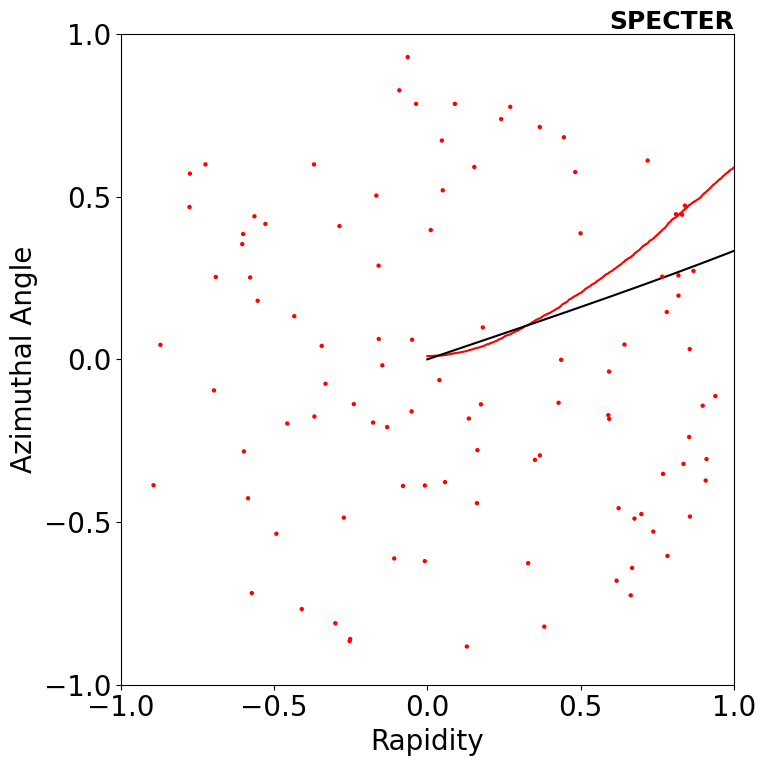

In [15]:
fig, ax = newplot()
circle = sample_circle({"Radius" : 1.0}, 100, 0)
print(compute_single_event(circle,learning_rate=0.1, finite_difference=False))
print(r_opt(circle))


print
print(closed_form_sEMD(circle,1))

plot_event(ax, circle, 1)

spectral_circle = compute_spectral_representation(circle)
print(spectral_circle)
plt.plot(spectral_circle[:,0], np.cumsum(spectral_circle[:,1]))
plt.plot(spectral_circle[:,0], 2 * 1 *  np.arcsin(spectral_circle[:,0] / 2) / np.pi)

In [16]:
event_1 = np.array(((0.5, 0, 0), (0.5, 0, 1)))
event_2 = np.array(((0.5, 0, 0), (0.5, 0, 2)))

spectral_1 = compute_spectral_representation(event_1)
spectral_2 = compute_spectral_representation(event_2)

print(spectral_1)
print(spectral_2)

print(ds2_events1_spectral2(event_1, spectral_2))

[[0.  0.5]
 [1.  0.5]]
[[0.  0.5]
 [2.  0.5]]
0.5


In [17]:


sEMDs, shape_events, losses = compute_single_event(dataset[0])

# # precompute
# with jax.profiler.trace("/tmp/jax-trace-123", create_perfetto_link=True):
#     sEMDs, shape_events, losses = compute_events(dataset[:50], 0.001, 150, finite_difference=False)


N_events = dataset.shape[0]
batch_size = 100
epochs = 150

sEMDs = np.zeros((N_events,))
shape_events = {"Radius" : np.zeros((N_events,))}
losses = np.zeros((epochs, N_events))
for (i, start) in (enumerate(range(0 , N_events, batch_size))):

    print("Batch", i, "of", N_events // batch_size)
    sEMDs[start:start+batch_size], r, losses[:,start:start+batch_size] = compute_events(dataset[start:start+batch_size], 0.005, epochs, N_sample = 50, finite_difference=True)
    shape_events["Radius"][start:start+batch_size] = r["Radius"]


# filename = f"{this_study}_sEMDs.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, sEMDs)

# filename = f"{this_study}_params.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, shape_events["Radius"])

# # plot the average loss per epoch
# plt.plot(np.mean(losses, axis = -1))
# plt.yscale("log")

100%|██████████| 150/150 [00:05<00:00, 25.20it/s]


Batch 0 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:34<00:00,  4.34it/s]


Batch 1 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.46it/s]


Batch 2 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.44it/s]


Batch 3 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.43it/s]


Batch 4 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.47it/s]


Batch 5 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.45it/s]


Batch 6 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.50it/s]


Batch 7 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.51it/s]


Batch 8 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.54it/s]


Batch 9 of 10
(100, 2776, 2) (100, 75, 3)


100%|██████████| 150/150 [00:27<00:00,  5.48it/s]


[0.01220097 0.0076227  0.00356542 0.00313086 0.00416467 0.00606758
 0.00320119 0.00883884 0.00104034 0.00681783 0.00239117 0.00570052
 0.00526281 0.00421761 0.00569769 0.00195301 0.00400668 0.00707142
 0.00595903 0.00491626 0.00386698 0.0075274  0.00109618 0.00784359
 0.00267904 0.0041267  0.00582089 0.00422464 0.00375183 0.01262899
 0.01168407 0.00657125 0.00434572 0.00376593 0.00422715 0.00835245
 0.00578975 0.00644475 0.00653817 0.00824155 0.0039332  0.00587212
 0.00345745 0.0035352  0.00879299 0.00180994 0.00318364 0.00629549
 0.00526898 0.00291922 0.00708054 0.00219702 0.00271842 0.00746465
 0.00407785 0.00662702 0.00467114 0.00257584 0.00196191 0.00565462
 0.00291728 0.00528479 0.00928335 0.00445311 0.00966804 0.00689734
 0.00577727 0.0046346  0.00392868 0.00241853 0.00503524 0.00293835
 0.00576824 0.00336321 0.005289   0.00404727 0.00691044 0.00428773
 0.00398543 0.00139006 0.00384806 0.00559413 0.00195823 0.00283819
 0.00284052 0.00377925 0.0058977  0.01004639 0.00117567 0.0075

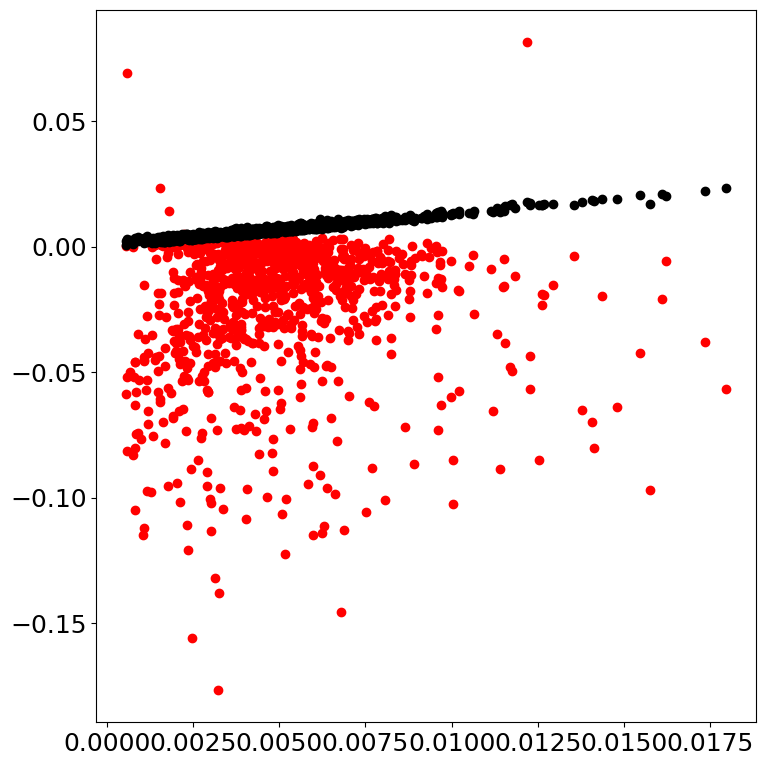

In [18]:
sEMDs_closed_r = vmapped_closed_form_sEMD(dataset, shape_events["Radius"])

print(sEMDs, sEMDs_closed_r)
plt.scatter(sEMDs, sEMDs_closed_r)
plt.scatter(sEMDs, r2)

(1000,)
[0.1        0.13659541 0.17779286 0.13605568 0.08977123 0.16838302
 0.16894804 0.08490495 0.33736673 0.16060571 0.11811525 0.09939376
 0.17148551 0.16765089 0.14011112 0.19201611 0.0768415  0.12621984
 0.19794258 0.12367156 0.054439   0.09141928 0.18733968 0.08976729
 0.1242327  0.12048272 0.11464416 0.20032343 0.27336645 0.18237154
 0.24064238 0.1439143  0.05038454 0.13504671 0.09700377 0.17163952
 0.12060462 0.0754807  0.1092676  0.15735026 0.15068309 0.11705768
 0.21765333 0.12588044 0.15594321 0.02865659 0.03328739 0.34045503
 0.17138176 0.16520411 0.10075895 0.25458464 0.09881604 0.13703768
 0.31588081 0.12735923 0.13871001 0.11202177 0.03271827 0.19713376
 0.13060616 0.08305405 0.16030139 0.08013449 0.1488875  0.1306738
 0.11608217 0.07741608 0.16554238 0.1480933  0.14808534 0.06042342
 0.10609395 0.09374233 0.07158929 0.19505344 0.12317405 0.12470265
 0.0772966  0.02424265 0.12435953 0.22841959 0.13517292 0.18030159
 0.15519938 0.18640614 0.11078668 0.30613571 0.1615105 

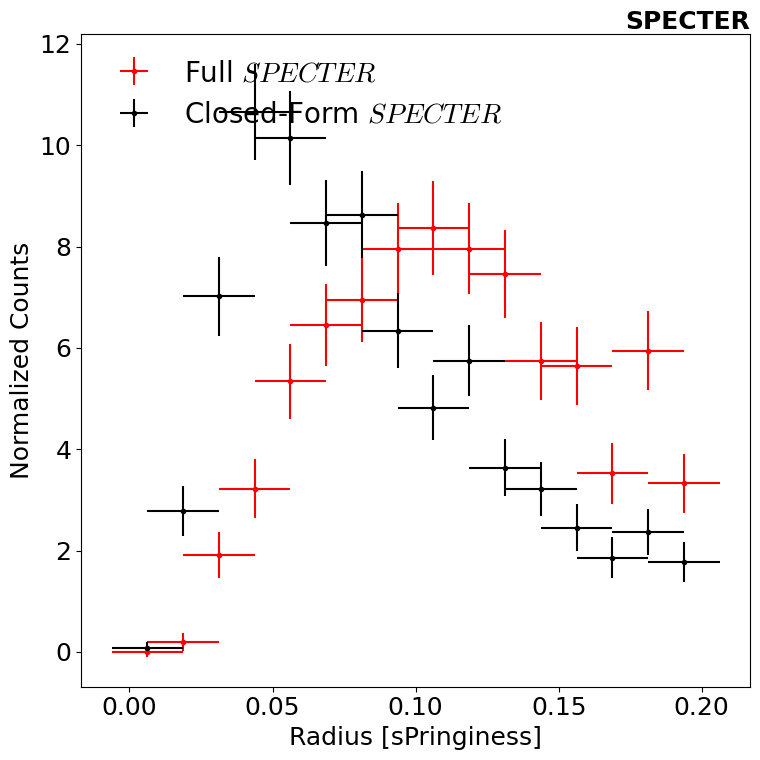

In [19]:
print(sEMDs.shape)
print(shape_events["Radius"])

# Function to take a list of points and create a histogram of points with sqrt(N) errors, normalized to unit area
def hist_with_errors(ax, points, bins, range, weights = None, **kwargs):

    if weights is None:
        weights = np.ones_like(points)

    hist, bin_edges = np.histogram(points, bins = bins, range = range, weights = weights)
    errs2 = np.histogram(points, bins = bins, range = range, weights = weights**2)[0] + 1

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1])

    hist_tot = np.sum(hist * bin_widths)
    hist = hist / hist_tot
    errs2 = errs2 / (hist_tot**2)

    ax.errorbar(bin_centers, hist, np.sqrt(errs2), xerr = bin_widths, fmt = ".", **kwargs)



fig, ax = newplot()
hist_with_errors(ax, shape_events["Radius"], bins = 16, range = (0, 0.2), label = R"Full $SPECTER$")
hist_with_errors(ax, closed_form_r, bins = 16, range = (0, 0.2), label = R"Closed-Form $SPECTER$")

# plt.hist(shape_events["Radius"], bins = 16, range = (0, 1.6), density = True)
plt.xlabel("Radius [sPringiness]")
plt.ylabel("Normalized Counts")
plt.legend(frameon = False, loc = "upper left")



# Closed Form Expressions

In [20]:
# closed_form_sEMDs = closed_form_2_spronginess(dataset, levels = 150)
# print(closed_form_sEMDs)


# filename = f"{this_study}_closed_form_sEMDs.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, closed_form_sEMDs)

# SHAPER

In [8]:
# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Generate new events

R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(dataset.shape[0]):

    event = dataset[i]

    zs = event[:,0]
    points = event[:,1:3]

    events.append((points, zs))


# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["1-Diskiness"]

# Collect our observables in one dictionary
observables = {}
observables["1-Ringiness"] = _2subjettiness
observables["1-Ringiness"].freeze("Points", torch.zeros((1,2)))



# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
params = []


batch_size = 1000

for i in range(0, len(events), batch_size):
    print("Batch", i, "of", len(events) // batch_size)
    dataset_emds, dataset_params = shaper.calculate(events[i:i+batch_size], epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
    for j in range(dataset_emds["1-Ringiness"].shape[0]):
        e = dataset_params["1-Ringiness"][j]["EMD"]
        EMDs.append(e)
        params.append(dataset_params["1-Ringiness"][j]["Radius"])




EMDs = np.array(EMDs)
params = np.array(params)


plt.hist(params)
print(np.mean(params))

filename = f"{this_study}_shaper_EMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, EMDs)

filename = f"{this_study}_shaper_params.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, params)

Using CPU!
Batch 0 of 10
Observable: 1-Ringiness Epoch 0 Mean Loss = 0.006783876732530189 Elapsed time = 4.036s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 1 Mean Loss = 0.006768176651399699 Elapsed time = 7.601s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 2 Mean Loss = 0.0067051007877889784 Elapsed time = 11.244s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 3 Mean Loss = 0.0065892622151732215 Elapsed time = 14.809s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 4 Mean Loss = 0.006429931767706875 Elapsed time = 18.394s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 5 Mean Loss = 0.006237656337296358 Elapsed time = 21.992s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 6 Mean Loss = 0.00602869278138678 Elapsed time = 25.597s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 7 Mean Loss = 0.00581689318511053 Elapsed time = 29.284s Percentage done = 0.000 
Observable: 1-Ringiness Epoch 8 Mean Loss = 0.005592288741914672 Elapsed 

KeyboardInterrupt: 

In [9]:
print(dataset_emds)


# EMDs = np.array(EMDs)
# params = np.array(params)

# filename = f"{this_study}_shaper_EMDs.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, EMDs)

# filename = f"{this_study}_shaper_params.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, params)

{'1-Ringiness': array([0.00261941, 0.00195822, 0.00427574, 0.0005495 , 0.00475762,
       0.0073497 , 0.003665  , 0.00303819, 0.00109072, 0.00473685,
       0.0021061 , 0.00188673, 0.00332464, 0.00821632, 0.0025369 ,
       0.0034337 , 0.00134996, 0.00377481, 0.00270855, 0.00191546,
       0.00182812, 0.00174003, 0.00061619, 0.00333355, 0.00060719,
       0.00129722, 0.00238054, 0.00481691, 0.00148673, 0.00133331,
       0.0040108 , 0.00162543, 0.00174446, 0.00169552, 0.00320204,
       0.00802555, 0.0040546 , 0.00193862, 0.00355779, 0.00231778,
       0.00149938, 0.00245537, 0.00347325, 0.00118288, 0.00257308,
       0.00331333, 0.00184618, 0.00157257, 0.00569962, 0.00210264,
       0.00171443, 0.00307062, 0.00340928, 0.00367942, 0.00135943,
       0.00205092, 0.00157496, 0.00189972, 0.00060736, 0.00332569,
       0.00232824, 0.00156978, 0.00268454, 0.00990234, 0.00561898,
       0.00676841, 0.00062223, 0.0073404 , 0.0031193 , 0.00613127,
       0.00136578, 0.00194006, 0.00366873, 0.0

# Plots

FileNotFoundError: [Errno 2] No such file or directory: 'cmsopendata_closed_form_sEMDs.npy'

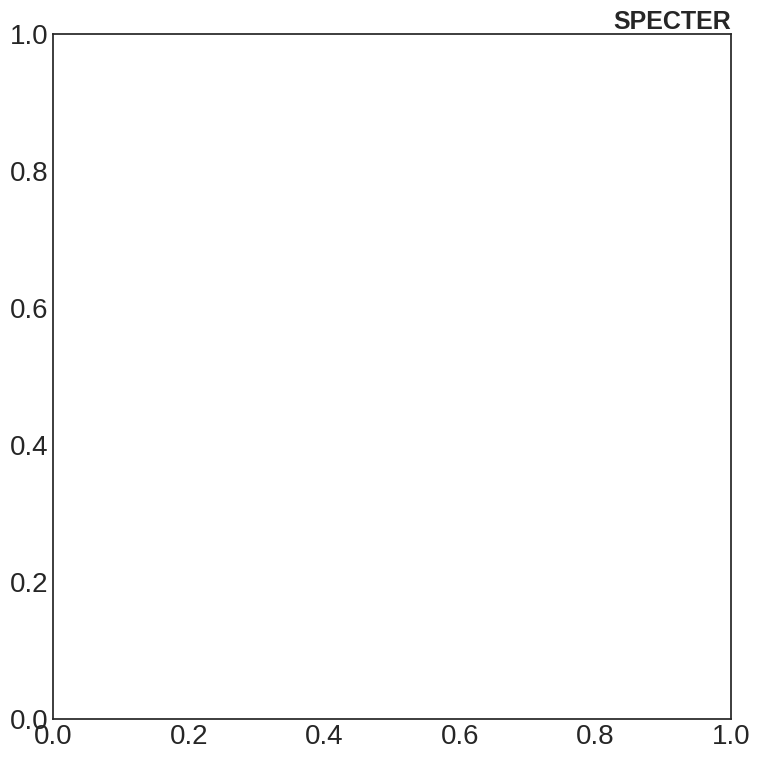

In [ ]:
fig, ax = newplot()

# Load numpy data
sEMDs = np.load(os.path.join(this_dir, f"{this_study}_sEMDs.npy"))
closed_form_sEMDs = np.load(os.path.join(this_dir, f"{this_study}_closed_form_sEMDs.npy"))
EMDs = np.load(os.path.join(this_dir, f"{this_study}_shaper_EMDs.npy"))


plt.scatter(2 * EMDs**2, closed_form_sEMDs, color = "red", alpha = 0.5)
plt.scatter(2 * EMDs**2,  sEMDs, color = "blue", alpha = 0.5)



plt.xscale("log")
plt.yscale("log")
plt.xlabel("2-Subjettiness ($SHAPER$)")
plt.ylabel("2-Sprubjetiness ($SPECTER$)")

# Dashed line at y = x
x = np.linspace(0, np.max(sEMDs), 100)
plt.plot(x, x, linestyle = "--", color = "black")

# print the MSE in the top left
mse = np.mean((np.maximum(sEMDs, 0) - closed_form_sEMDs)**2)
plt.text(0.05, 0.95, "MSE: %.3e\n1000 Events" % mse, transform=ax.transAxes, fontsize=14,)

# print the percentage of events that differ by more than temp1%
diff = (sEMDs - (2 * EMDs**2)) / (2 * EMDs**2)
print(np.sum(diff > 0.10))
# plt.scatter(np.maximum(sEMDs, 0)[diff > 0.10], closed_form_sEMDs[diff > 0.10])

# ax.set_aspect('equal')

In [ ]:
# Plot a histogram of the differences
fig, ax = newplot()
plt.hist(diff, bins = 50 )

# plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fractional Error")
